In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='yash0606',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = '/Users/yashyadav/Desktop/ecom project'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db= mysql.connector.connect(host="localhost",
                            username="root",
                            password="yash0606",
                            database="ecommerce")
cur=db.cursor()


# 1. List all unique cities where customers are located.

In [106]:
query=""" select distinct upper(customer_city) from customers"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["City"])
df

,City
0,FRANCA
1,SAO BERNARDO DO CAMPO
2,SAO PAULO
3,MOGI DAS CRUZES
4,CAMPINAS
...,...
4114,SIRIJI
4115,NATIVIDADE DA SERRA
4116,MONTE BONITO
4117,SAO RAFAEL


# 2. Count the number of orders placed in 2017.

In [17]:
query=""" select count(order_id) from orders
where year(order_purchase_timestamp)=2017"""
cur.execute(query)
data=cur.fetchall()
"The total count of orders placed in 2017 -",data[0][0]

('The total count of orders placed in 2017 -', 45101)

# 3. Find the total sales per category.

In [104]:
query=""" SELECT 
    UPPER(products.product_category) AS Category,
    ROUND(SUM(payments.payment_value), 2) AS Sales
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
        JOIN
    payments ON payments.order_id = order_items.order_id
GROUP BY category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [26]:
query=""" select sum(case when payment_installments>=1 then 1 else 0 end)
/ count(*)*100 from payments"""
cur.execute(query)
data=cur.fetchall()
"The percentage of orders that were paid in installments-",data[0][0]

('The percentage of orders that were paid in installments-',
 Decimal('99.9981'))

# 5. Count the number of customers from each state. 

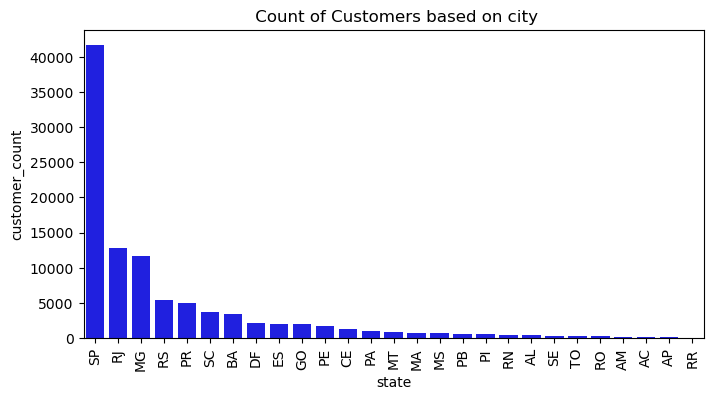

In [64]:
query=""" select customer_state,count(customer_id) from customers
group by customer_state"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["state","customer_count"])
df=df.sort_values(by="customer_count", ascending=False)
plt.figure(figsize=(8,4))
ax=sns.barplot(x=df["state"],y=df["customer_count"],data=df,color="blue")
plt.xticks(rotation=90)
plt.title(" Count of Customers based on city")
plt.show()


# 6.  Calculate the number of orders per month in 2018.

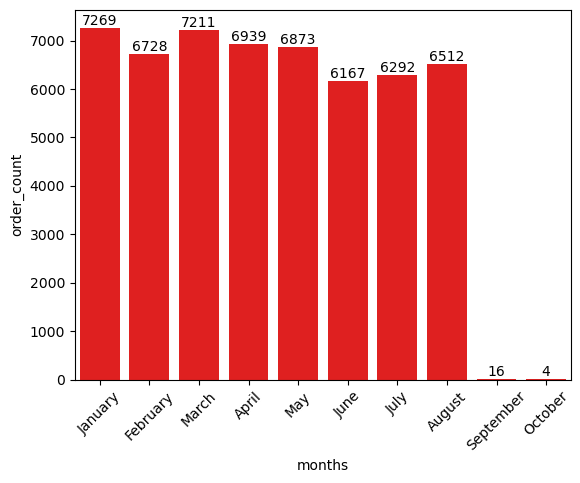

In [51]:
query = """select monthname(order_purchase_timestamp) as months,
count(order_id) order_count from ecommerce.orders
where year(order_purchase_timestamp)=2018
group by months """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["months","order_count"])
o=["January","February","March","April","May","June","July","August","September","October"]
ax=sns.barplot(x=df["months"],y=df["order_count"],data=df,order=o,color="red")
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.show()

# 7. Find the average number of products per order, grouped by customer city.

In [66]:
query="""with count_per_order as 
(select orders.order_id,orders.customer_id,
count(order_items.order_id) as oc from orders join order_items on
orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)
select customers.customer_city,round(avg(count_per_order.oc),2)
from customers join count_per_order on
customers.customer_id=count_per_order.customer_id
group by customers.customer_city"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer_city","average_orders"])
df.head()

,customer_city,average_orders
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27


# 8. Calculate the percentage of total revenue contributed by each product category.

In [70]:
query=""" SELECT 
    UPPER(products.product_category) AS Category,
    round((SUM(payments.payment_value)/(select sum(payment_value) from payments))*100,2) as sales
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
        JOIN
    payments ON payments.order_id = order_items.order_id
GROUP BY category order by sales desc"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","revenue_percentage"])
df.head()

,category,revenue_percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# 9.  Identify the correlation between product price and the number of times a product has been purchased.

In [74]:
import numpy as np
query=""" select round(avg(order_items.price),2) as average_price ,products.product_category,
count(order_items.product_id) as order_count from products join order_items on
products.product_id=order_items.product_id
group by products.product_category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["average_price","product-category","order_count"])
arr1=df["order_count"]
arr2=df["average_price"]
a=np.corrcoef([arr1,arr2])
print(" The correlation between product price and the number of times a product has been purchased is ", a[0][-1])



 The correlation between product price and the number of times a product has been purchased is  -0.10631514167157562


# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

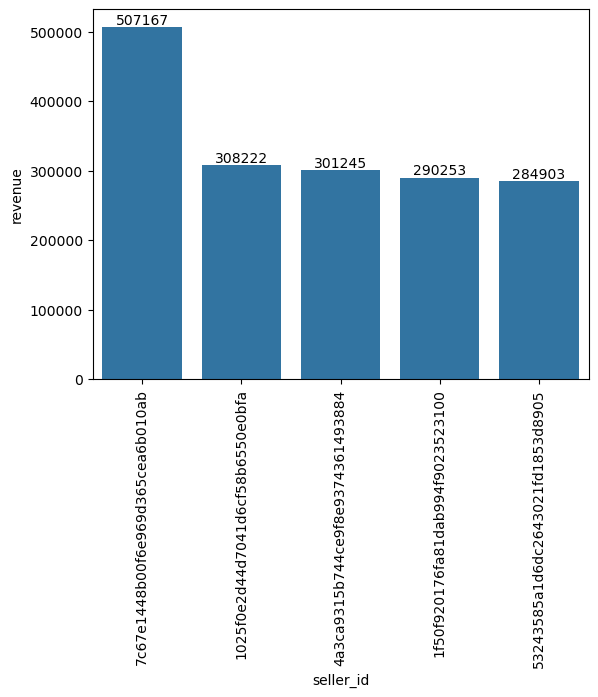

In [83]:
query=""" select 
    a.*, 
    dense_rank() over (order by revenue desc) as rn
from (
    select  
        order_items.seller_id,
        sum(payments.payment_value) as revenue
    from order_items 
    join payments 
        on order_items.order_id = payments.order_id
    group by order_items.seller_id
) as a;
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["seller_id","revenue","rn"])
df=df.head()
ax=sns.barplot(x="seller_id",y="revenue",data=df)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.show()


# 11. Calculate the moving average of order values for each customer over their order history.

In [84]:
query="""select customer_id,order_purchase_timestamp,avg(payment_value) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as moving_average
from
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value
from orders join payments on
orders.order_id=payments.order_id) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=[" customer_id","order_purchase_timestamp","moving_average"])
df

,customer_id,order_purchase_timestamp,moving_average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002
...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000


# 12. Calculate the cumulative sales per month for each year.

In [86]:
query="""select years,months,payment,round(sum(payment)over(order by years,months),2) as cum_sales
from
( select year(orders.order_purchase_timestamp) as years,
monthname(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments on 
orders.order_id=payments.order_id
group by years,months 
order by years,months)AS A """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","months","payment","cum_sales"])
df


,years,months,payment,cum_sales
0,2016,December,19.62,19.62
1,2016,October,59090.48,59110.10
2,2016,September,252.24,59362.34
3,2017,April,417788.03,477150.37
4,2017,August,674396.32,1151546.69
5,2017,December,878401.48,2029948.17
6,2017,February,291908.01,2321856.18
7,2017,January,138488.04,2460344.22
8,2017,July,592382.92,3052727.14
9,2017,June,511276.38,3564003.52


# 13. Calculate the year-over-year growth rate of total sales.

In [90]:
query="""with a as (
    select 
        year(orders.order_purchase_timestamp) as years,
        sum(payments.payment_value) as payment
    from orders 
    join payments 
        on orders.order_id = payments.order_id
    group by year(orders.order_purchase_timestamp)
)
select 
    years,
    ((payment - lag(payment,1) over (order by years)) 
        / lag(payment,1) over (order by years)) * 100 as growth_percent,
    lag(payment,1) over (order by years) as prev_payment
from a
order by years
 """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","growth_percentage","previous_payment"])
df

,years,growth_percentage,previous_payment
0,2016,NaN,NaN
1,2017,12112.703760,5.936234e+04
2,2018,20.000924,7.249747e+06


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [91]:
query="""with a as (
    select 
        customers.customer_id,
        min(orders.order_purchase_timestamp) as first_order
    from customers 
    join orders 
        on customers.customer_id = orders.customer_id
    group by customers.customer_id
),
b as (
    select 
        a.customer_id,
        count(distinct orders.order_id) as repeat_orders
    from a
    join orders 
        on a.customer_id = orders.customer_id
       and orders.order_purchase_timestamp > a.first_order
       and orders.order_purchase_timestamp < date_add(a.first_order, interval 6 month)
    group by a.customer_id
)
select 
    100.0 * count(distinct b.customer_id) / count(distinct a.customer_id) as repeat_rate_percent
from a
left join b on a.customer_id = b.customer_id """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["repeat_rate_percentage"])
df

,repeat_rate_percentage
0,0.00000


# 15. Identify the top 3 customers who spent the most money in each year.

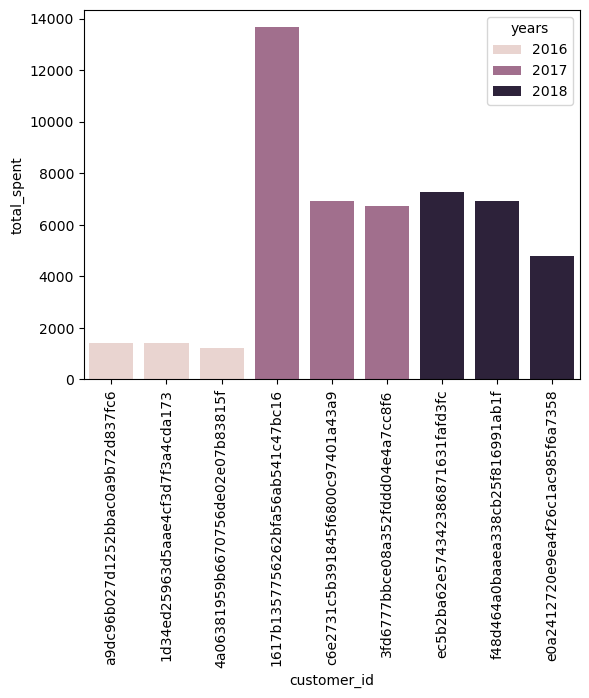

In [102]:
query="""select *
from (
    select 
        year(o.order_purchase_timestamp) as years,
        c.customer_id,
        sum(p.payment_value) as total_spent,
        dense_rank() over (
            partition by year(o.order_purchase_timestamp) 
            order by sum(p.payment_value) desc
        ) as rn
    from customers c
    join orders o 
        on c.customer_id = o.customer_id
    join payments p 
        on o.order_id = p.order_id
    group by year(o.order_purchase_timestamp), c.customer_id
) as ranked_customers
where rn <= 3
order by years, rn
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","customer_id","total_spent","rank"])
df
sns.barplot(x="customer_id",y="total_spent",data=df,hue="years")
plt.xticks(rotation=90)
plt.show()